In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cmocean import cm
import os
import re
import numpy as np
from matplotlib import cm as mpl_cm
import math
import json
from datetime import datetime, timedelta

from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

from plot_metric_utils import calculate_weighted_mse, setup_figure_layout, render_panel, crop_spatial_bounds, plot_Nckpts_1leadtime, get_forecast_and_truth_data, calculate_mse_for_ckpts_and_leadtimes

import warnings
warnings.filterwarnings('ignore')

In [2]:
figs_dir = '/projectnb/eb-general/wade/sfno/inference/figures'
json_config = '/projectnb/eb-general/wade/sfno/inference/configs/exp2.json'
with open(json_config, 'r') as f:
    config = json.load(f)
ar_bb=config['experiment_setup']['bounding_box']

# convert the values to be float 
for key in ar_bb:
    ar_bb[key] = float(ar_bb[key])
    
ckpts = [1,11,21,31,41,51,61,71,89]
odd_ckpts = np.arange(1,90,2)

Truth total amplitude within contour: 115709.6
ckpt_num: 1, Model pred total amplitude: 11478.4
ckpt_num: 11, Model pred total amplitude: 87828.0
ckpt_num: 21, Model pred total amplitude: 100191.5
ckpt_num: 31, Model pred total amplitude: 140131.3
ckpt_num: 41, Model pred total amplitude: 148341.1
ckpt_num: 51, Model pred total amplitude: 134625.4
ckpt_num: 61, Model pred total amplitude: 117613.2
ckpt_num: 71, Model pred total amplitude: 127964.6
ckpt_num: 89, Model pred total amplitude: 114055.1


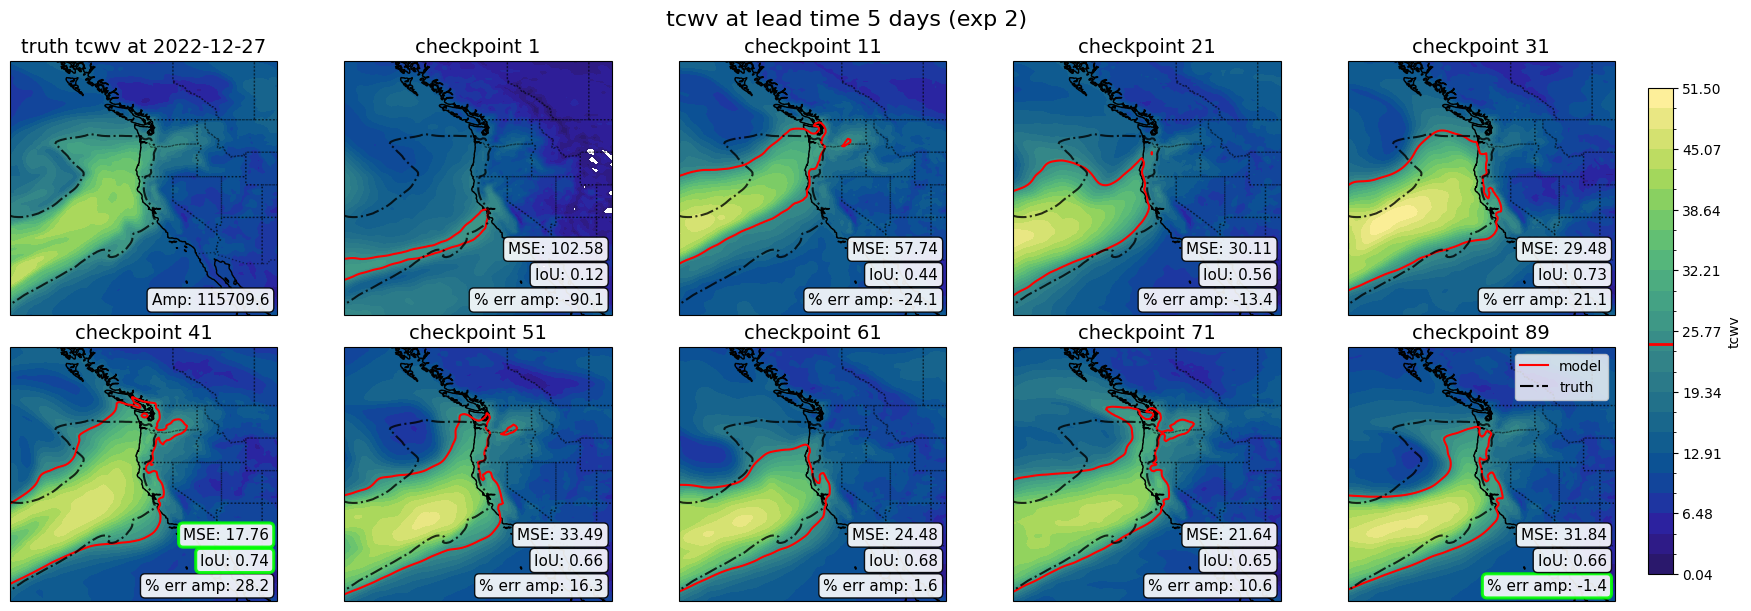

In [3]:
cbar_min, cbar_max, contour_val = plot_Nckpts_1leadtime(leadtime=5, ckpts=ckpts, plot_truth=True, experiment_number=2,
    valid_timestep_str="2022_12_27T00", init_timestep_str="2022_12_22T00", contour_percentile=80, white_negative_values=True, 
    plot_truth_contour=True, var='tcwv', bounding_box=ar_bb, save_fig=False)

Truth total amplitude within contour: 115709.6
ckpt_num: 1, Model pred total amplitude: 11478.4
ckpt_num: 3, Model pred total amplitude: 92960.9
ckpt_num: 5, Model pred total amplitude: 85120.8
ckpt_num: 7, Model pred total amplitude: 89214.3
ckpt_num: 9, Model pred total amplitude: 56817.1
ckpt_num: 11, Model pred total amplitude: 87828.0
ckpt_num: 13, Model pred total amplitude: 115732.2
ckpt_num: 15, Model pred total amplitude: 101268.6
ckpt_num: 17, Model pred total amplitude: 116427.3
ckpt_num: 19, Model pred total amplitude: 80071.2
ckpt_num: 21, Model pred total amplitude: 100191.5
ckpt_num: 23, Model pred total amplitude: 86337.2
ckpt_num: 25, Model pred total amplitude: 118877.2
ckpt_num: 27, Model pred total amplitude: 112898.8
ckpt_num: 29, Model pred total amplitude: 82038.8
ckpt_num: 31, Model pred total amplitude: 140131.3
ckpt_num: 33, Model pred total amplitude: 109628.5
ckpt_num: 35, Model pred total amplitude: 70822.5
ckpt_num: 37, Model pred total amplitude: 100045.8

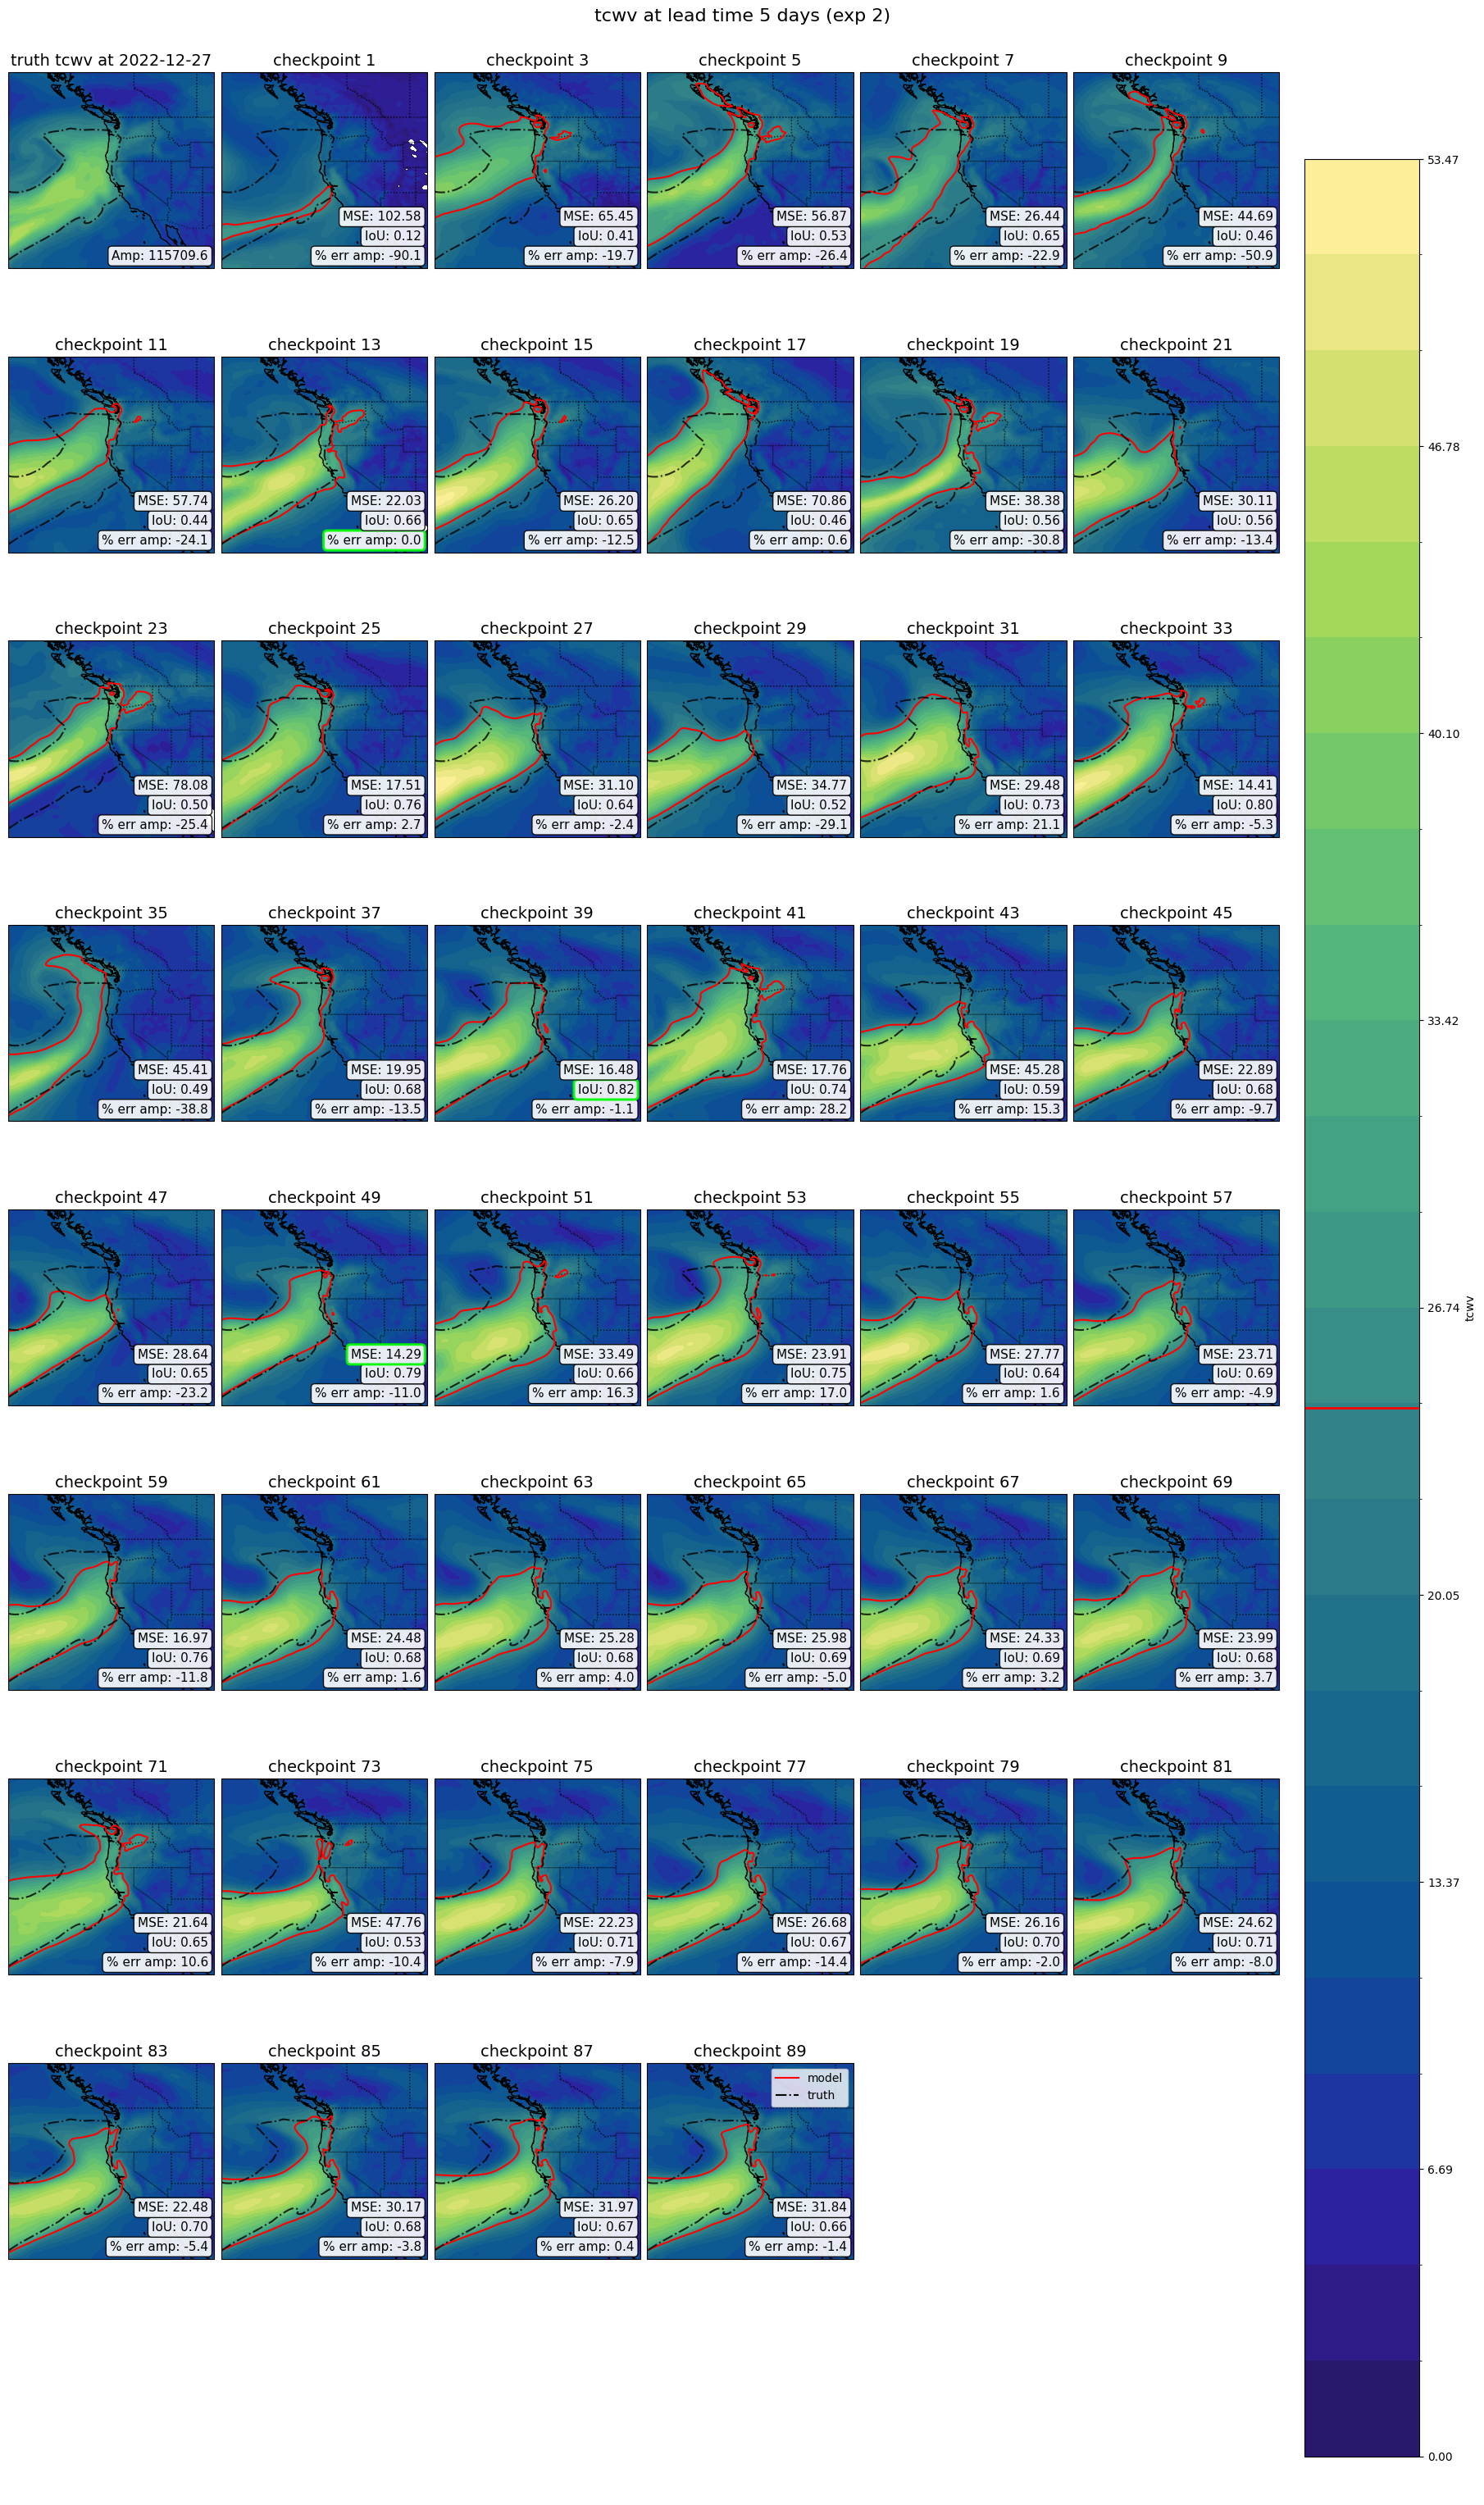

In [5]:
cbar_min, cbar_max, contour_val = plot_Nckpts_1leadtime(leadtime=5, ckpts=odd_ckpts, plot_truth=True, experiment_number=2,
    valid_timestep_str="2022_12_27T00", init_timestep_str="2022_12_22T00", contour_percentile=80, white_negative_values=True, 
    plot_truth_contour=True, var='tcwv', bounding_box=ar_bb, save_fig=False)

Truth total amplitude within contour: 115709.6
ckpt_num: 1, Model pred total amplitude: 18688.8
ckpt_num: 11, Model pred total amplitude: 49154.4
ckpt_num: 21, Model pred total amplitude: 23398.7
ckpt_num: 31, Model pred total amplitude: 28043.7
ckpt_num: 41, Model pred total amplitude: 136062.9
ckpt_num: 51, Model pred total amplitude: 129670.4
ckpt_num: 61, Model pred total amplitude: 58299.8
ckpt_num: 71, Model pred total amplitude: 132944.8
ckpt_num: 89, Model pred total amplitude: 110709.8


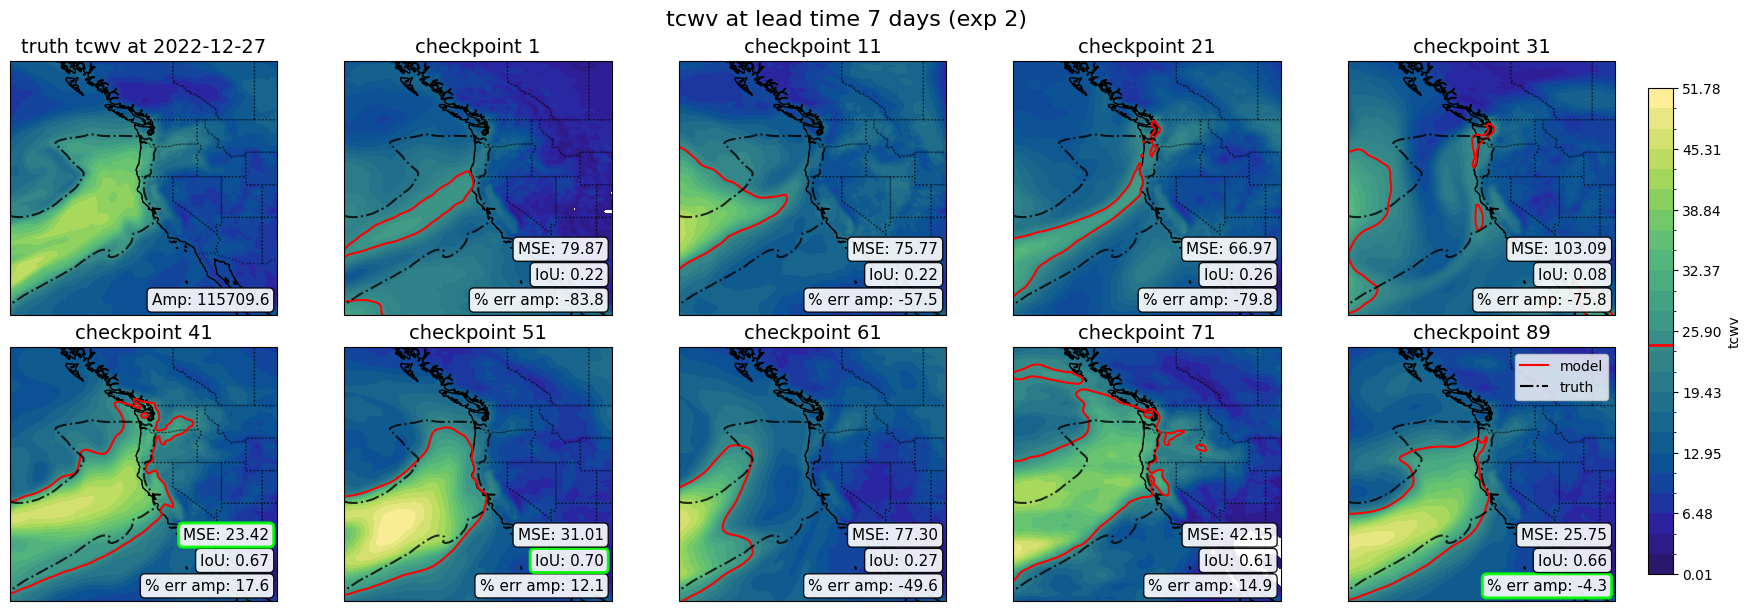

In [4]:
cbar_min, cbar_max, contour_val = plot_Nckpts_1leadtime(leadtime=7, ckpts=ckpts, plot_truth=True, experiment_number=2,
    valid_timestep_str="2022_12_27T00", init_timestep_str="2022_12_20T00", contour_percentile=80, white_negative_values=True, 
    plot_truth_contour=True, var='tcwv', bounding_box=ar_bb, save_fig=False)

### Plot metrics as a function of checkpoint

In [102]:
# # change the font of my matplotlib settings
# plt.rcParams['font.family'] = 'serif'

In [22]:
def mse_ckpt_leadtimes(ckpts, mses, var, experiment_number, highlight_min = True):
    # Make a plot of MSE vs ckpt for different lead times
    fig,ax = plt.subplots(figsize=(6,4))

    cmap = cm.matter
    colors = {
        3: cmap(0.2),
        5: cmap(0.5),
        7: cmap(0.8)
    }
    for leadtime in [3,5,7]:
        mses_select = mses[leadtime]
        ax.plot(ckpts, mses_select, label=f'leadtime={leadtime} days', color=colors[leadtime], alpha=0.9, linewidth=2, marker='o', markersize=2)

    if highlight_min:
        # find the minimum mse for each leadtime and highlight it with a star
        for leadtime in [3,5,7]:
            mses_select = mses[leadtime]
            min_idx = np.argmin(mses_select)
            # if there are points within 0.5 stdev from the minimum, highlight them too
            stdev = np.std(mses_select)
            for i, mse in enumerate(mses_select):
                threshold = mses_select[min_idx] + 0.05 * stdev
                if mse <= threshold:
                    ax.plot(ckpts[i], mse, marker='*', color=colors[leadtime], markersize=8, alpha=0.75)
                    # ax.text(ckpts[i]-0.03, mse,'🌟',fontsize=10) 
            ax.plot(ckpts[min_idx], mses_select[min_idx], marker='*', color=colors[leadtime], markersize=8,)
            # ax.text(ckpts[min_idx]-0.03, mses_select[min_idx],'★',fontsize=12)

    ax.set_xlabel('Checkpoint')
    # make the xlabel have finer ticks for ckpts
    ax.set_xticks(ckpts)
    xticklabels = [str(ckpt) if i % 3 == 0 else ''  for i, ckpt in enumerate(ckpts) ]
    ax.set_xticklabels(xticklabels, )
    ax.set_ylabel(r"$\text{mse}_w$")
    ax.set_title(f'latitude-weighted MSE of {var} for experiment {experiment_number} event')
    ax.legend()
    plt.yscale('log')
    plt.tight_layout()
    output_dir = figs_dir + f'/exp{experiment_number}/'
    plt.savefig(f'{output_dir}/{var}_mse_vs_ckpt_leadtimes.png', dpi=300)
    plt.show()

In [20]:
var = 'tcwv'
mses = calculate_mse_for_ckpts_and_leadtimes(ckpts=odd_ckpts, leadtimes=[3,5,7], var=var, experiment_number=2, 
    valid_timestep_str=config['experiment_setup']['valid_timestep'], bounding_box=ar_bb)

In [ ]:
mse_ckpt_leadtimes(ckpts=odd_ckpts, mses=mses, experiment_number=2, var=var)

In [ ]:
var = 'u700'
mses = calculate_mse_for_ckpts_and_leadtimes(ckpts=odd_ckpts, leadtimes=[3,5,7], var=var, experiment_number=2, 
    valid_timestep_str=config['experiment_setup']['valid_timestep'], bounding_box=ar_bb)
mse_ckpt_leadtimes(ckpts=odd_ckpts, mses=mses, experiment_number=2, var=var)

In [ ]:
var = 'v700'
mses = calculate_mse_for_ckpts_and_leadtimes(ckpts=odd_ckpts, leadtimes=[3,5,7], var=var, experiment_number=2, 
    valid_timestep_str=config['experiment_setup']['valid_timestep'], bounding_box=ar_bb)
mse_ckpt_leadtimes(ckpts=odd_ckpts, mses=mses, experiment_number=2, var=var)